In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### imports

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


np.random.seed(55)
%matplotlib inline

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

## EDA

In [4]:
print(df_train.isna().sum())
print(df_train.info())
print(df_train.columns)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Non

In [5]:
(df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending = False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [6]:
df_train.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace = True)
df_test.drop(['Cabin', 'Ticket', 'Name'], axis=1,inplace=True)

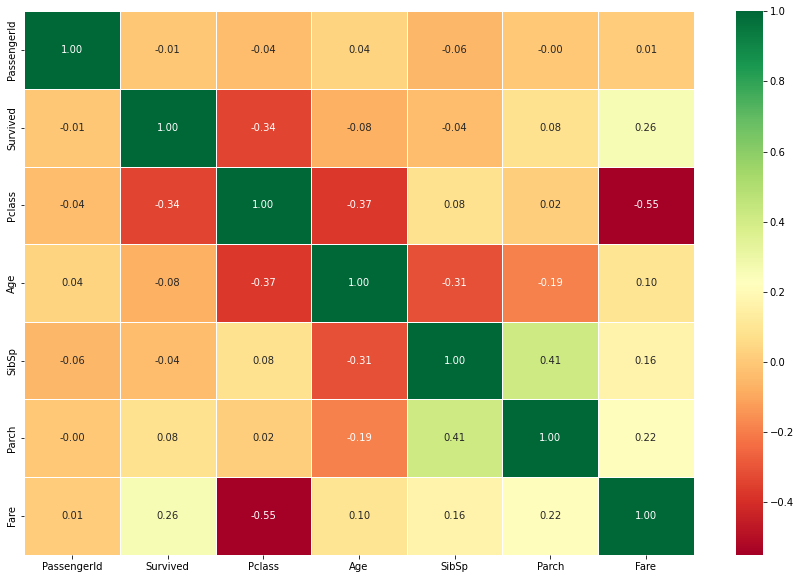

In [7]:
corr_matrix = df_train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdYlGn");

In [8]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_train[label] = content.fillna(content.mean())
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_test[label] = content.fillna(content.mean())

In [9]:
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace = True)
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace = True)

In [10]:
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [11]:
data = [df_train, df_test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Sex              891 non-null    object 
 4   Age              891 non-null    float64
 5   SibSp            891 non-null    int64  
 6   Parch            891 non-null    int64  
 7   Fare             891 non-null    float64
 8   Embarked         891 non-null    object 
 9   relatives        891 non-null    int64  
 10  travelled_alone  891 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


In [13]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,relatives,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,travelled_alone_No,travelled_alone_Yes
0,892,3,34.5,0,0,7.8292,0,0,1,0,1,0,0,1
1,893,3,47.0,1,0,7.0000,1,1,0,0,0,1,1,0
2,894,2,62.0,0,0,9.6875,0,0,1,0,1,0,0,1
3,895,3,27.0,0,0,8.6625,0,0,1,0,0,1,0,1
4,896,3,22.0,1,1,12.2875,2,1,0,0,0,1,1,0


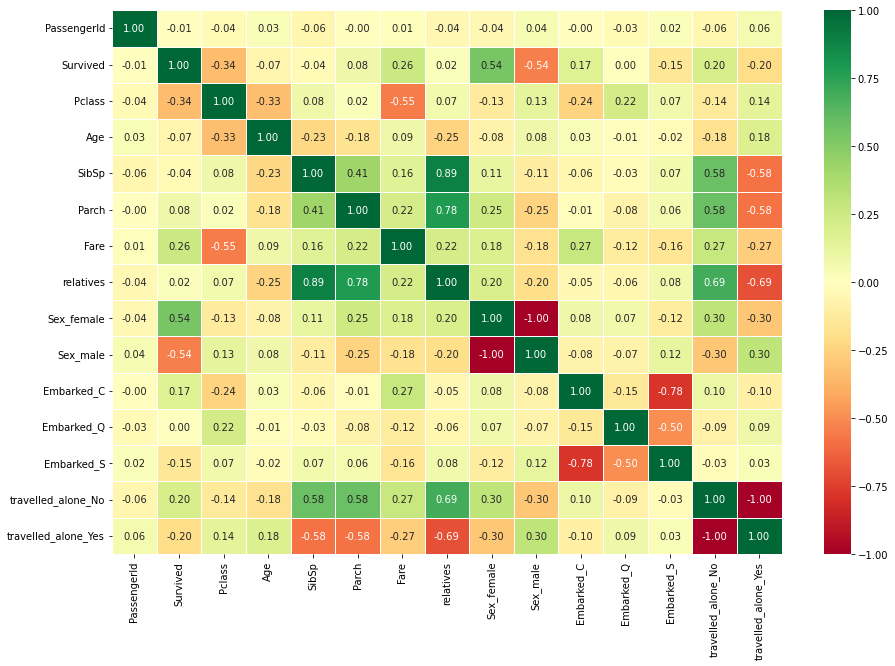

In [14]:
corr_matrix = df_train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdYlGn");

## Modeling

In [23]:
X = df_train.drop(['Survived', 'PassengerId'], axis=1)
y = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = RandomForestClassifier(n_jobs=1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=1)

In [24]:
model.score(X_test, y_test)

0.776536312849162

## Tune Hyper-Params

In [25]:
rf_grid = {"n_estimators": np.arange(10, 160, 5),
          "max_depth": [None, 3, 5, 10, 15, 20],
          "min_samples_split": np.arange(2, 25, 1),
          "min_samples_leaf": np.arange(1, 26, 2),
          "max_features": [0.5, 1, "sqrt", "auto", "log2"]}
rs_model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1, random_state=1),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=2,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   51.7s finished


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10, 15, 20],
                                        'max_features': [0.5, 1, 'sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155])},
                   verbose=True)

In [26]:
rs_model.best_params_

{'n_estimators': 140,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [27]:
tune_model = RandomForestClassifier(n_jobs=-1,
                                    random_state=1,
                                    n_estimators=140,
                                   min_samples_split=8,
                                   min_samples_leaf=1,
                                   max_features='sqrt',
                                   max_depth=10)
tune_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=8,
                       n_estimators=140, n_jobs=-1, random_state=1)

In [28]:
  tune_model.score(X_test, y_test)

0.7821229050279329

In [30]:
test_preds = tune_model.predict(df_test.drop('PassengerId', axis=1))

In [32]:
df_preds = pd.DataFrame()
df_preds["PassengerId"] = df_test["PassengerId"]
df_preds["Survived"] = test_preds
df_preds

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [35]:
df_preds.to_csv("./predictions.csv",
                index=False)